# Emission Retrieval

Here's a real-life example of an atmospheric retrieval from
secondary-eclipse emission observation of the ultra-hot Jupiter
WASP-18b using ``Pyrat Bay``.

---

Lets break the steps down:

1. [Setup](#Setup)
    - [Observation Files](#observation-files)
    - [Stellar SED Spectrum](#stellar-sed-spectrum)
    - [Cross Sections](#cross-sections)
    - [Configuration File](#configuration-file)
2. [Run Retrieval](#Run-Retrieval)
3. [Post-Processing](#Post-Processing)

---

## Setup

We will retrieve atmospheric properties of the planet WASP-18b, constrained by secondary-eclipse observations from JWST, Spitzer, CHEOPS, and TESS.

### Observation Files

We will constrain this retrieval to the JWST, Spitzer, CHEOPS, and TESS emission observations.  So we need to collect that data.  For the JWST spectroscopic observations we will use the NAMELESS spectral reduction (available on Zenodo https://zenodo.org/records/7907569), which we will model as a series of top-hat narrow passbands.

The CHEOPS (Deline et al. 2024), TESS (Coulombe et al. 2023), and Spitzer (Sheppard et al. 2020) consists of broad photometric passbands. For these we will use the passband filter files.

`Pyrat Bay` contains all of this information into an observation file input.  These scripts below show how to create observation files for (1) the JWST observations, and (2) all photometric and spectroscopic observations combined.

In [1]:
# Save JWST data
import numpy as np
import pyratbay.io as io

jwst_data = np.loadtxt('NAMELESS_W18b_spectrum.txt', unpack=True)
jwst_wl, jwst_depths, jwst_depth_uncerts, jwst_half_widths = jwst_data
njwst = len(jwst_wl)

# Save JWST data:
obs_file = 'obs_wasp18b_emission_jwst.dat'
jwst_inst_names = ['NIRISS' for _ in jwst_wl]
io.write_observations(
    obs_file,
    jwst_inst_names,
    jwst_wl, jwst_half_widths,
    jwst_depths, jwst_depth_uncerts, depth_units='ppm',
)

In [2]:
# Save JWST + Spitzer + CHEOPS + TESS data:
sheppard2017_spitzer = [2973, 3858, 3700, 4100]
sheppard2017_spitzer_uncerts = [70.0, 113, 300, 200]

coulombe2023_tess = 357.0
coulombe2023_tess_uncert = 14.0

ndata = 2 + njwst + 4 
depths = np.zeros(ndata)
depth_uncerts = np.zeros(ndata)

depths[0] = coulombe2023_tess
depths[1] = coulombe2023_tess
depths[2:2+njwst] = jwst_depths
depths[-4:] = sheppard2017_spitzer

depth_uncerts[0] = coulombe2023_tess_uncert
depth_uncerts[1] = coulombe2023_tess_uncert
depth_uncerts[2:2+njwst] = jwst_depth_uncerts
depth_uncerts[-4:] = sheppard2017_spitzer_uncerts

# Leaving the wavelenght values at zero signals to use the instrument
# name as a path to a passband file (for broadband photometry)
wl = np.zeros(ndata)
half_widths = np.zeros(ndata)
wl[2:2+njwst] = jwst_wl
half_widths[2:2+njwst] = jwst_half_widths

spitzer_inst_names = [ 
    f'{{ROOT}}/pyratbay/data/filters/spitzer_irac{i+1}_sa.dat'
    for i in range(4)
]
inst_names = [ 
    'CHEOPS.dat',
    'TESS.dat',
]
inst_names += jwst_inst_names + spitzer_inst_names

obs_file = 'obs_wasp18b_emission_all.dat'
io.write_observations(
    obs_file,
    inst_names,
    wl, half_widths,
    depths, depth_uncerts, depth_units='ppm',
)

### Stellar SED Spectrum

The stellar SED is required to calculate the planet-to-star flux ratio. Here we will use a stellar SED for WASP-18 from the PHOENIX models (ref. needed), which we will get using the ``Gen TSO`` package.  If you haven't already, install this package with this command:

```shell
pip install gen_tso
```

Now, we can create the stellar SED spectrum with this Python script:

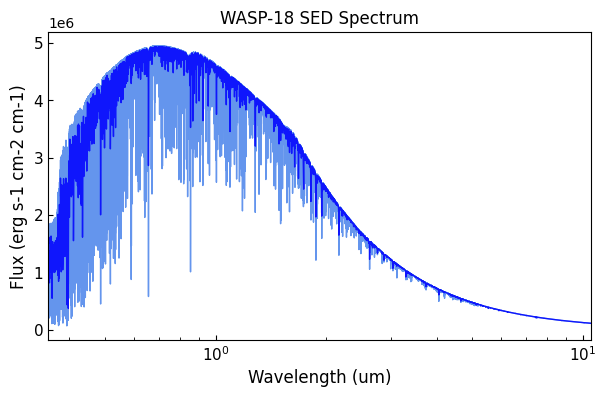

In [17]:
import gen_tso.pandeia_io as pandeia
import pyratbay.constants as pc
import pyratbay.spectrum as ps
import matplotlib.pyplot as plt


# Use the Gen TSO package to get a PHOENIX SED model for WASP-18 (teff=6430.0, logg=4.31)
# Closest SED to WASP-18 is an F5V model (Teff=6500K, logg=4.0)
scene = pandeia.make_scene(
    sed_type='phoenix',
    sed_model='f5v',
)
sed_wl, flux = pandeia.extract_sed(scene, wl_range=(0.35,12.0))
# Convert flux from mJy to erg s-1 cm-2 cm-1
sed_flux = flux * pc.c / 1e26

# Lower the resolution to something closer to NIRISS
bin_wl = ps.constant_resolution_spectrum(0.35, 12.0, resolution=1500.0)
bin_sed_flux = ps.bin_spectrum(bin_wl, sed_wl, sed_flux, gaps='interpolate')

# Save to file
starspec_file = 'phoenix_F5V_6500K_WASP18.dat'
io.write_spectrum(
    bin_wl,
    bin_sed_flux,
    starspec_file,
    type='emission',
)

# Take a look
plt.figure(0, (7,4))
plt.clf()
ax = plt.subplot(111)
ax.plot(sed_wl, sed_flux, lw=1.0, color='cornflowerblue')
ax.plot(bin_wl, bin_sed_flux, lw=1.0, color='blue', alpha=0.85)
ax.set_title('WASP-18 SED Spectrum')
ax.set_xscale('log')
ax.set_xlim(0.35, 10.5)
ax.set_xlabel('Wavelength (um)', fontsize=12)
ax.set_ylabel('Flux (erg s-1 cm-2 cm-1)', fontsize=12)
ax.tick_params(direction='in', which='both', labelsize=11)

### Cross Sections

To simulate the planetary atmosphere's response to stellar radiation, we need cross-sectional data for relevant molecular absorbers.

[Sample Cross sections](https://pyratbay.readthedocs.io/en/ver2.0/cookbooks/cross_sections_wasp18b/uhj_cross_sections.html)


### Configuration File


<details open>
<summary>Shopping list</summary>

* Vegetables
* Fruits
* Fish

</details>

<details> <summary>Click to expand configuration file</summary>

```ini
[pyrat]
# Pyrat Bay run mode, select from: [tli atmosphere spectrum opacity retrieval]
runmode = retrieval

# Output log and spectrum file names:
logfile = ret_all/NS_WASP18b_emission_all.log

# Observing geometry, select between: [transit emission]
rt_path = emission

# System parameters
rstar = 1.23 rsun
mstar = 1.27 msun
tstar = 6435.0
    
rplanet = 1.165 rjup
mplanet = 10.38 mjup
smaxis = 0.020 au
tint = 0.01
refpressure = 0.1 bar

# Wavelength sampling:
wllow  = 0.35 um
wlhigh = 10.5 um

# Stellar SED model
starspec = phoenix_F5V_6500K_WASP18.dat
   
# Atmospheric model:   
nlayers = 81
ptop = 1e-9 bar
pbottom = 1e2 bar
   
species =
    H  He  C  O  N  Na  K  S  Si  Fe  Ti  V
    H2  H2O  CH4  CO  CO2  HCN  NH3  N2  OH  C2H2  C2H4
    S2  SH  SiO  H2S  SO2  SO  TiO  VO  TiO2  VO2
    e-  H-  H+  H2+  He+  Na-  Na+  K-  K+  Fe+  Ti+  V+

tmodel = madhu
tpars = -3.0 -1.25 1.75 1.0 0.3 2850.0

chemistry = tea 
radmodel = hydro_m

# The data:
dunits = ppm
obsfile = obs_wasp18b_emission_all.dat

# opacity files:
extfile = 
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_H2O.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_hitemp_CO.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_hitemp_CO2.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_TiO.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_VO.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_C2H2.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_HCN.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_exomol_NH3.npz
    ../run00_setup/cross_section_0250-4000K_0.35-12.0um_R020K_hitemp_CH4.npz


# Cross-section opacity files:
csfile =
    {ROOT}/pyratbay/data/CIA/CIA_Borysow_H2H2_0060-7000K_0.6-500um.dat
    {ROOT}/pyratbay/data/CIA/CIA_Borysow_H2He_0050-7000K_0.5-031um.dat

# Rayleigh models, select from: [lecavelier dalgarno_H dalgarno_He dalgarno_H2]
rayleigh =
    dalgarno_H2
    dalgarno_H
    dalgarno_He

alkali =
    sodium_vdw
    potassium_vdw

h_ion = h_ion_john1988

vmr_vars = [M/H] [C/H] [O/H]

retrieval_params =
#  param       value  pmin  pmax  pstep  prior
   log_p1      -3.0    -9.0     2.0   0.3
   log_p2      -1.25   -9.0     2.0   0.3
   log_p3       1.75   -9.0     2.0   0.3
   a1           1.00    0.2     2.0   0.02
   a2           0.30    0.2     2.0   0.02
   T0         2850.0  500.0  4000.0   30.0
   [M/H]       1.50    -2.0     2.5   0.1
   [C/H]       0.5     -2.0     2.5   0.1
   [O/H]       0.0     -2.0     2.5   0.1

# Retrieval setting
sampler = multinest
nlive = 1500
resume = True
statistics = med_central
theme = orange
post_processing = False

# MCMC temperature boundaries:
tlow  =  500
thigh = 4000

# Verbosity level (<0:errors, 0:warnings, 1:headlines, 2:details, 3:debug):
verb = 2
logxticks = 0.5 0.7 1.0 1.4 2.0 3.0 5.0 8.0
```

</details>

---

## Run Retrieval

Now that we have the necessary setup, we can run the retrieval using `Pyrat Bay`. This step will involve processing the data through the retrieval algorithm to model the planetary atmosphere.

``Pyrat Bay`` 2.0 can run retrievals using Multinest Nested Sampling and MPI parallel computing.  Be sure to install multinest and MPI on your machine.  Once you have that working, make sure to have these Python packages installed:

```shell
pip install pymultinest
pip install mpi4py
```

This is how you launch the retrieval:

```shell
mpirun -n 128 pbay -c ns_WASP18b_emission_retrieval_all.cfg
mpirun -n 128 pbay -c ns_WASP18b_emission_retrieval_jwst.cfg
```

---

## Post-Processing

Once the retrieval is complete, we will analyze the results to interpret the atmospheric composition and properties of WASP-18b. This includes plotting outputs and examining confidence intervals to assess our model accuracy.

---

With these steps, we can complete an atmospheric retrieval for WASP-18b.
